In [1]:
import sys
assert sys.version_info >= (3,7)

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os
import pandas as pd
from math import floor

# Define function

In [3]:
def plot_image(img, title=None, img2=None, title2=None):
    """
    function to display two images side by side
    img = image to display
    title = title for image one
    img2 = second image, optional
    title2 = title for image two, optional
    """
    if img2 is None:
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.xticks([]), plt.yticks([])
    else:
        fig, ax = plt.subplots(1, 2, figsize=(10, 10))
        ax[0].imshow(img, cmap='gray')
        ax[0].set_title(title)
        ax[1].imshow(img2, cmap='gray')
        ax[1].set_title(title2)
        ax[0].set_axis_off()
        ax[1].set_axis_off()

def load_image_single(img_path, data, img_name=None, random=True):
    """
    function to load a single image, return the image in RGB and the ground truth in x1, y1, x2, y2
    img_path: the path of the folder that contains the images
    data: annotation in pandas dataframe
    img_name: the name of the image, default to None
    random: set this to True then a random image in the file path will be loaded, default to True
    """
    if random:
        idx = np.random.randint(0, len(data))
        img = cv.imread(img_path + "/" + data.iloc[idx]['filename'])
        print(data.iloc[idx]['filename'])
        x1 = data.iloc[idx]['x1']
        y1 = data.iloc[idx]['y1']
        x2 = data.iloc[idx]['x2']
        y2 = data.iloc[idx]['y2']
        return cv.cvtColor(img, cv.COLOR_BGR2RGB), (x1, y1, x2, y2)
    else:
        idx = data.index[data['filename'] == img_name]
        img = cv.imread(img_path + "/" + data.iloc[idx]['filename'].values[0])
        x1 = data.iloc[idx]['x1'].values[0]
        y1 = data.iloc[idx]['y1'].values[0]
        x2 = data.iloc[idx]['x2'].values[0]
        y2 = data.iloc[idx]['y2'].values[0]
        return cv.cvtColor(img, cv.COLOR_BGR2RGB), (x1, y1, x2, y2)
        
def load_image(img_path, data):
    """
    function to load all the images in the path, return a list of images in RGB and the ground truths in x1, y1, x2, y2
    img_path: the path of the folder that contains the images
    data: annotation in pandas dataframe
    """
    imgs = []
    bbs = []
    names = []
    for i in range(len(data)):
        img = cv.imread(img_path + "/" + data.iloc[i]['filename'])
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        imgs.append(img)
        x1 = data.iloc[i]['x1']
        y1 = data.iloc[i]['y1']
        x2 = data.iloc[i]['x2']
        y2 = data.iloc[i]['y2']
        bbs.append((x1, y1, x2, y2))
        names.append(data.iloc[i]['filename'])
    return imgs, bbs, names

def preprocess(img, bb, width):
    """
    Resize the image and apply bilateral filter, return the resized image and ground truth bounding box
    bb: bounding box in x1, y1, x2, y2
    """
    factor = width / img.shape[1]
    img_resize = cv.resize(img, None, fx=factor, fy=factor)
    img_smooth = cv.bilateralFilter(img_resize, 5, 75, 150)
    
    # scale the bounding box according to the  factor
    x1 = floor(bb[0] * factor)
    y1 = floor(bb[1] * factor)
    x2 = floor(bb[2] * factor)
    y2 = floor(bb[3] * factor)
    return img_smooth, (x1, y1, x2, y2)

def thresholding_pipeline(img, th_type=cv.ADAPTIVE_THRESH_GAUSSIAN_C, th_bsize=7, th_c=0, open_kernel=3):
    """
    Convert to grayscale, perform CLAHE, thresholding, morphological operation, find the contour and then return bounding box in x1,y1,x2,y2
    img: image in RGB
    th_type: default to thresh_gaussian_c
    th_bsize: blockSize for thresholding, default to 7
    th_c: constant in thresholding, default to 0
    open_kernel: size of kernel for morphological opening, default to 3
    """
    # convert to grayscale
    img_gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    
    # clahe
    clahe = cv.createCLAHE(clipLimit=3, tileGridSize=(5,5))
    img_clahe = clahe.apply(img_gray)
    
    # thresholding
    th = cv.adaptiveThreshold(img_clahe, 255, th_type, cv.THRESH_BINARY_INV, th_bsize, th_c)
    
    # morphological opening
    kernel = np.ones((open_kernel,open_kernel),np.uint8)
    img_open = cv.morphologyEx(th, cv.MORPH_OPEN, kernel)
    
    # find the contours and calculate bounding box
    contours, hierarchy = cv.findContours(img_open, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    # if no contours
    if(len(contours) == 0):
        return (0, 0, 0, 0)
    
    contourAreaList = []
    for contour in contours:
        area = cv.contourArea(contour)
        contourAreaList.append(area)
    x, y, w, h = cv.boundingRect(contours[contourAreaList.index(max(contourAreaList))])
    return (x, y, x+w, y+h)
    
def computeIOU(boxA, boxB):
    """
    Args: in (x1, y1, x2, y2)
    """
    x_start = max(boxA[0], boxB[0])
    y_start = max(boxA[1], boxB[1])
    x_end = min(boxA[2], boxB[2])
    y_end = min(boxA[3], boxB[3])
    
    #max is to prevent negative value when two box does not overlap
    interArea = max(0, x_end - x_start + 1) * max(0, y_end - y_start + 1)
    
    #area of A and area of B
    areaA = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    areaB = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    return interArea / (areaA+areaB - interArea)

def auto_canny(img, method, sigma=0.33):
    """Args:
    img = grayscale image
    method = median, otsu, triangle
    sigma = 0.33 (default)
    """
    if method == "median":
        Th = np.median(img)
    elif method == "triangle":
        Th = cv.threshold(img, 0, 255, cv.THRESH_TRIANGLE)[0]
    elif method == "otsu":
        Th = cv.threshold(img, 0, 255, cv.THRESH_OTSU)[0]
        
    Thresh1 = (1-sigma) * Th
    Thresh2 = (1+sigma) * Th
    
    return cv.Canny(img, Thresh1, Thresh2)

def edge_detection_segmentation(img, method="otsu"):
    """
    Convert img to grayscale, perform CLAHE, find the edge using canny edge, find the contour and return bounding box in
    (x1, y1, x2, y2) format
    img: image in RGB
    method: method for thresholding used in finding the thresholds for canny edge detector, default to otsu
    """
    # convert to grayscale
    img_gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    
    # clahe
    clahe = cv.createCLAHE(clipLimit=3, tileGridSize=(5,5))
    img_clahe = clahe.apply(img_gray)
    
    # canny edge detector
    canny = auto_canny(img_clahe, method=method) 
    
    # find the contours and calculate bounding box
    contours, hierarchy = cv.findContours(canny, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    # if no contours
    if(len(contours) == 0):
        return (0, 0, 0, 0)
    
    contourAreaList = []
    for contour in contours:
        area = cv.contourArea(contour)
        contourAreaList.append(area)
    x, y, w, h = cv.boundingRect(contours[contourAreaList.index(max(contourAreaList))])
    return (x, y, x+w, y+h)
   
def edge_detection_visualization(img, method="otsu"):
    """
    Convert img to grayscale, perform CLAHE, find the edge using canny edge, find the contour
    Plot the result of each stage for visualization
    img: image in RGB
    method: method for thresholding used in finding the thresholds for canny edge detector, default to otsu
    """
    plt.figure(figsize=(10, 10))
    # convert to grayscale
    img_gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    plt.subplot(221), plt.imshow(img_gray, cmap=plt.cm.gray), plt.title("Grayscale")
    plt.xticks([]), plt.yticks([])
    
    # clahe
    clahe = cv.createCLAHE(clipLimit=3, tileGridSize=(5,5))
    img_clahe = clahe.apply(img_gray)
    plt.subplot(222), plt.imshow(img_clahe, cmap=plt.cm.gray), plt.title("CLAHE")
    plt.xticks([]), plt.yticks([])
    
    # canny edge detector
    canny = auto_canny(img_clahe, method=method) 
    plt.subplot(223), plt.imshow(canny, cmap=plt.cm.gray), plt.title("Edge detection")
    plt.xticks([]), plt.yticks([])
    
    # find the contours and calculate bounding box
    contours, hierarchy = cv.findContours(canny, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    contourAreaList = []
    if(len(contours) != 0):
        img_copy = img.copy()
        cv.drawContours(img_copy, contours, -1, (255, 0, 0), 2)
        plt.subplot(224), plt.imshow(img_copy, cmap=plt.cm.gray), plt.title("Contour")
        plt.xticks([]), plt.yticks([])
    plt.show()

## Read the annotation as pandas dataframe

In [4]:
img_path = "tsrd-train"
annotation = "TSRD-Train Annotation/TsignRecgTrain4170Annotation.txt"
header = ['filename', 'width', 'height', 'x1', 'y1', 'x2', 'y2', 'class']
if os.path.isfile(annotation):
    data = pd.read_csv(annotation, sep=';', header=None, index_col=False, names=header)
    print(data.head())
    print('Number of images: ', len(data))
else:
    print('File do not exist')

       filename  width  height  x1  y1   x2   y2  class
0  000_0001.png    134     128  19   7  120  117      0
1  000_0002.png    165     151  23  12  149  138      0
2  000_0003.png    128     122  22  14  116  105      0
3  000_0010.png     80      73  14   8   67   63      0
4  000_0011.png    186     174  36  15  155  157      0
Number of images:  4170


## Run all the images with Edge detection

In [6]:
# load all the images
imgs, bbs, names = load_image(img_path=img_path, data=data)

In [7]:
ious = []
gt_bbs = []
result_bbs = []
for i in range(len(imgs)):
    img, gt_bb = preprocess(imgs[i], bbs[i], 100)
    result_bb = edge_detection_segmentation(img)
    iou = computeIOU(result_bb, gt_bb)
    ious.append(iou)
    result_bbs.append(result_bb)
    gt_bbs.append(gt_bb)

In [8]:
iou_th = 0.55

# convert to numpy array
ious_np = np.array(ious)
names_np = np.array(names)
result_bbs_np = np.array(result_bbs)
gt_bbs_np = np.array(gt_bbs)

success_iou = ious_np[ious_np > iou_th]
success_name = names_np[ious_np > iou_th]
success_bbs = result_bbs_np[ious_np > iou_th]
success_gt = gt_bbs_np[ious_np > iou_th]

# sort according to the IOU in descending order
sortIdx = success_iou.argsort()[::-1]
success_iou = success_iou[sortIdx]
success_name = success_name[sortIdx]
success_bbs = success_bbs[sortIdx]
success_gt = success_gt[sortIdx]

print(success_name.shape)
print(success_gt.shape)
print(success_bbs.shape)
print(success_iou.shape)

(2506,)
(2506, 4)
(2506, 4)
(2506,)


Successfully segmented 2506 images

## Comparison with thresholding

In [9]:
iou_th = 0.55

th_ious = []
for i in range(len(imgs)):
    img, gt_bb = preprocess(imgs[i], bbs[i], 100)
    result_bb = thresholding_pipeline(img, th_bsize=7, th_c=0, open_kernel=3)
    iou = computeIOU(result_bb, gt_bb)
    th_ious.append(iou)


ed_ious = []
for i in range(len(imgs)):
    img, gt_bb = preprocess(imgs[i], bbs[i], 100)
    result_bb = edge_detection_segmentation(img)
    iou = computeIOU(result_bb, gt_bb)
    ed_ious.append(iou)
    
th_ious_np = np.array(th_ious)
ed_ious_np = np.array(ed_ious)
names_np = np.array(names)

th_success_name = names_np[th_ious_np > iou_th]
ed_success_name = names_np[ed_ious_np > iou_th]

In [10]:
print(th_success_name.shape)
print(ed_success_name.shape)

(3620,)
(2506,)


In [11]:
name_list = list(set(ed_success_name.tolist()) - set(th_success_name.tolist()))
print(len(name_list))

212


212 images cannot be segmented by thresholding but can be segmented by edge detection

### Traffic sign that cannot be segmented by thresholding, but can be segmented by edge detection

029_1_0008.png


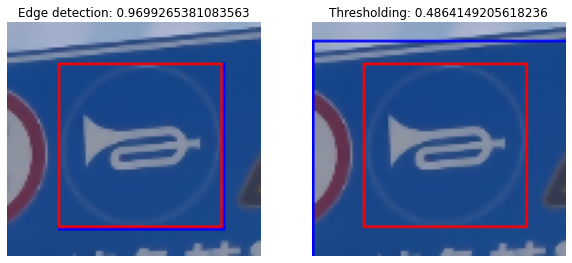

In [12]:
idx = np.random.randint(0, len(name_list))
img, gt_bb = load_image_single(img_path, data, img_name=name_list[idx], random=False)
print(name_list[idx])

img1, gt_bb1 = preprocess(img, gt_bb, 100)
result_bb1 = edge_detection_segmentation(img1, method="otsu")
img_copy1 = img1.copy()
cv.rectangle(img_copy1, (result_bb1[0],result_bb1[1]), (result_bb1[2],result_bb1[3]), (0,0,255), 1)
cv.rectangle(img_copy1, (gt_bb1[0],gt_bb1[1]), (gt_bb1[2],gt_bb1[3]), (255,0,0), 1)
ed_iou = computeIOU(result_bb1, gt_bb1)


img2, gt_bb2 = preprocess(img, gt_bb, 100)
result_bb2 = thresholding_pipeline(img2)
img_copy2 = img2.copy()
cv.rectangle(img_copy2, (result_bb2[0],result_bb2[1]), (result_bb2[2],result_bb2[3]), (0,0,255), 1)
cv.rectangle(img_copy2, (gt_bb2[0],gt_bb2[1]), (gt_bb2[2],gt_bb2[3]), (255,0,0), 1)
th_iou = computeIOU(result_bb2, gt_bb2)

plot_image(img_copy1, ("Edge detection: "+str(ed_iou)) , img_copy2, ("Thresholding: "+str(th_iou)))

## Integration of Thresholding and Edge detection

In [13]:
def integrated_pipeline(img, gt_bb, th_type=cv.ADAPTIVE_THRESH_GAUSSIAN_C, th_bsize=7, th_c=0, open_kernel=3, method="otsu"):
    
    result_bb = thresholding_pipeline(img, th_bsize=th_bsize, th_c=th_c, open_kernel=open_kernel)
    iou = computeIOU(result_bb, gt_bb)
    if(iou > 0.55):
        return result_bb
    
    result_bb = edge_detection_segmentation(img, method="otsu")
    return result_bb

In [14]:
ious = []
gt_bbs = []
result_bbs = []
for i in range(len(imgs)):
    img, gt_bb = preprocess(imgs[i], bbs[i], 100)
    result_bb = integrated_pipeline(img, gt_bb)
    iou = computeIOU(result_bb, gt_bb)
    ious.append(iou)
    result_bbs.append(result_bb)
    gt_bbs.append(gt_bb)

In [15]:
iou_th = 0.55
ious_np = np.array(ious)
success_iou = ious_np[ious_np > iou_th]
print(success_iou.shape)

(3832,)


3620 from thresholding + 212 from edge detection = 3832